By: Gani Perez

github: @GaniPerez

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# COVID-19 Time-Series Case/Death Prediction

In this dataset, I would like to model the evolution of COVID-19 cases and deaths in the DMV area. I have a number of datasets from the CDC regarding cases, deaths, and vaccination rates per county, and I will do some small exploratory analyses to look at some potential relationships in order to decide on which features to add into the model. Additionally, I have a bunch of per-county metadata that I pulled from the latest (2019) census report. Unfortunately, a key piece of the puzzle (at least, in terms of predicting deaths) is the hospital utilization, but I haven't been able to find any per-county dataset with this information without scraping the Maryland COVID-19 Dashboard. I don't know how to do that.

My features:
- Longitudinal Features:
    - Cases
    - Deaths
    - Vaccination Rates
- Other Metadata:
    - Fertility Info
    - Health Insurance Characteristics
    - Private Health Insurance
    - Income
    - Poverty Status
    - Social/Demographic Characteristics
    - Work/Economic Characteristics
 
There is a lot of data cleaning that needs to be done, so for now I focused on cleaning and analyzing only the longitudinal features. There is some cleaning of the other metadata at the bottom of this notebook, but it has not yet been completed.

### Cleaning up Time Series Data

First, I will start by defining a few functions to help me clean. Later, I will probably package these functions into a class for easy automation.

In [8]:
def process_US_info(df):
    df_t = df.transpose()
    df_t.columns = df_t.loc["Province_State"]
    df_t.rename(columns={"Admin2": "County"}, inplace=True)
    df_t.drop("Province_State", inplace=True)
    df_t.reset_index(inplace=True)
    return df_t

def clean_state_name(name):
    name = name.split('.')[0]
    return name

def melt_df(df, label):
    df2 = pd.melt(df, id_vars=["index", "County"], value_vars=df.columns[1:])
    df2.columns = ["state", "county", "date", label]
    df2 = df2.astype({label:'float'})
    df2 = df2.astype({label:'int'})
    df2['state'] = np.vectorize(clean_state_name)(df2['state'])
    return df2

def select_states(df, states):
    states_string = "|".join(states)
    df2 = df[df['state'].str.match(states_string)]
    return df2
    

#### Starting with deaths by county...

In [9]:
deaths = pd.read_csv("US_deaths.csv", low_memory=False)
deaths

,Province_State,Alabama,Alabama.1,Alabama.2,Alabama.3,Alabama.4,Alabama.5,Alabama.6,Alabama.7,Alabama.8,...,Wyoming.15,Wyoming.16,Wyoming.17,Wyoming.18,Wyoming.19,Wyoming.20,Wyoming.21,Wyoming.22,Wyoming.23,Wyoming.24
0,Admin2,Autauga,Baldwin,Barbour,Bibb,Blount,Bullock,Butler,Calhoun,Chambers,...,Park,Platte,Sheridan,Sublette,Sweetwater,Teton,Uinta,Unassigned,Washakie,Weston
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,3/3/22,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
772,3/4/22,0.0,5.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,3/5/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,3/6/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
deaths_t = process_US_info(deaths)
deaths_long = melt_df(deaths_t, "deaths")
deaths_long

,state,county,date,deaths
0,Alabama,Autauga,1/23/20,0
1,Alabama,Baldwin,1/23/20,0
2,Alabama,Barbour,1/23/20,0
3,Alabama,Bibb,1/23/20,0
4,Alabama,Blount,1/23/20,0
...,...,...,...,...
2590045,Wyoming,Teton,3/7/22,0
2590046,Wyoming,Uinta,3/7/22,0
2590047,Wyoming,Unassigned,3/7/22,0
2590048,Wyoming,Washakie,3/7/22,0


For now, I am only interested in longitudinal data from the DMV area.

In [5]:
states = ["District of Columbia", "Maryland", "Virginia"]
deaths_long_selected = select_states(deaths_long, states)
deaths_long_selected

,state,county,date,deaths
339,District of Columbia,District of Columbia,1/23/20,0
340,District of Columbia,Out of DC,1/23/20,0
341,District of Columbia,Unassigned,1/23/20,0
1239,Maryland,Allegany,1/23/20,0
1240,Maryland,Anne Arundel,1/23/20,0
...,...,...,...,...
2589848,Virginia,Williamsburg,3/7/22,0
2589849,Virginia,Winchester,3/7/22,0
2589850,Virginia,Wise,3/7/22,1
2589851,Virginia,Wythe,3/7/22,2


In [6]:
deaths_long_selected['date'] = pd.to_datetime(deaths_long_selected['date'])
deaths_long_selected

/tmp/ipykernel_319/3966188435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_long_selected['date'] = pd.to_datetime(deaths_long_selected['date'])


,state,county,date,deaths
339,District of Columbia,District of Columbia,2020-01-23,0
340,District of Columbia,Out of DC,2020-01-23,0
341,District of Columbia,Unassigned,2020-01-23,0
1239,Maryland,Allegany,2020-01-23,0
1240,Maryland,Anne Arundel,2020-01-23,0
...,...,...,...,...
2589848,Virginia,Williamsburg,2022-03-07,0
2589849,Virginia,Winchester,2022-03-07,0
2589850,Virginia,Wise,2022-03-07,1
2589851,Virginia,Wythe,2022-03-07,2


#### Next, positive case rates by county...

In [36]:
cases = pd.read_csv("US_confirmed_cases.csv", low_memory=False)
cases

,Province_State,Alabama,Alabama.1,Alabama.2,Alabama.3,Alabama.4,Alabama.5,Alabama.6,Alabama.7,Alabama.8,...,Wyoming.15,Wyoming.16,Wyoming.17,Wyoming.18,Wyoming.19,Wyoming.20,Wyoming.21,Wyoming.22,Wyoming.23,Wyoming.24
0,Admin2,Autauga,Baldwin,Barbour,Bibb,Blount,Bullock,Butler,Calhoun,Chambers,...,Park,Platte,Sheridan,Sublette,Sweetwater,Teton,Uinta,Unassigned,Washakie,Weston
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,3/3/22,-2.0,21.0,1.0,3.0,13.0,0.0,0.0,69.0,1.0,...,3.0,0.0,3.0,1.0,3.0,11.0,-3.0,0.0,0.0,0.0
772,3/4/22,4.0,18.0,0.0,3.0,4.0,1.0,0.0,16.0,2.0,...,3.0,2.0,2.0,1.0,2.0,14.0,3.0,0.0,1.0,0.0
773,3/5/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,3/6/22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
cases_t = process_US_info(cases)
cases_long = melt_df(cases_t, "cases")
cases_long

,state,county,date,cases
0,Alabama,Autauga,1/23/20,0
1,Alabama,Baldwin,1/23/20,0
2,Alabama,Barbour,1/23/20,0
3,Alabama,Bibb,1/23/20,0
4,Alabama,Blount,1/23/20,0
...,...,...,...,...
2590045,Wyoming,Teton,3/7/22,3
2590046,Wyoming,Uinta,3/7/22,-2
2590047,Wyoming,Unassigned,3/7/22,0
2590048,Wyoming,Washakie,3/7/22,-1


In [38]:
cases_long_selected = select_states(cases_long, states)
cases_long_selected

,state,county,date,cases
339,District of Columbia,District of Columbia,1/23/20,0
340,District of Columbia,Out of DC,1/23/20,0
341,District of Columbia,Unassigned,1/23/20,0
1239,Maryland,Allegany,1/23/20,0
1240,Maryland,Anne Arundel,1/23/20,0
...,...,...,...,...
2589848,Virginia,Williamsburg,3/7/22,-1
2589849,Virginia,Winchester,3/7/22,5
2589850,Virginia,Wise,3/7/22,40
2589851,Virginia,Wythe,3/7/22,12


In [100]:
cases_long_selected['date'] = pd.to_datetime(cases_long_selected['date'])
cases_long_selected

/tmp/ipykernel_149/2229495875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_long_selected['date'] = pd.to_datetime(cases_long_selected['date'])


,state,county,date,cases
339,District of Columbia,District of Columbia,2020-01-23,0
340,District of Columbia,Out of DC,2020-01-23,0
341,District of Columbia,Unassigned,2020-01-23,0
1239,Maryland,Allegany,2020-01-23,0
1240,Maryland,Anne Arundel,2020-01-23,0
...,...,...,...,...
2589848,Virginia,Williamsburg,2022-03-07,-1
2589849,Virginia,Winchester,2022-03-07,5
2589850,Virginia,Wise,2022-03-07,40
2589851,Virginia,Wythe,2022-03-07,12


In [84]:
### removes entries with null counties.
# cases_long = cases_long[~cases_long['county'].isnull()]
# cases_long

#### Vaccination Status

Unfortunately, per-county vaccination status came from a different data vendor so the structure is slightly different. I will do this cleaning manually.

In [179]:
vaccination = pd.read_csv("US_county_vaccination.csv", low_memory=False)
vaccination.head()

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_5PlusPop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,03/14/2022,22095,11,St. John the Baptist Parish,LA,96.8,29453.0,68.8,29452.0,73.5,...,4.0,4.0,4.0,4.0,4.0,42837.0,40059.0,36076.0,32355.0,6310.0
1,03/14/2022,39111,11,Monroe County,OH,98.6,7125.0,52.2,7125.0,54.9,...,7.0,7.0,8.0,8.0,8.0,13654.0,12971.0,11855.0,10931.0,3294.0
2,03/14/2022,47077,11,Henderson County,TN,97.8,13019.0,46.3,13017.0,49.1,...,7.0,7.0,7.0,8.0,8.0,28117.0,26489.0,24008.0,21774.0,5328.0
3,03/14/2022,27091,11,Martin County,MN,94.6,11492.0,58.4,11490.0,62.0,...,8.0,8.0,8.0,8.0,8.0,19683.0,18539.0,16886.0,15368.0,4747.0
4,03/14/2022,48253,11,Jones County,TX,99.0,10510.0,52.3,10509.0,54.7,...,3.0,3.0,3.0,4.0,3.0,20083.0,19216.0,17832.0,16601.0,3188.0


In [180]:
vaccination_subset = vaccination[["Date", "Recip_County", "Recip_State", 
                           "Completeness_pct", "Administered_Dose1_Pop_Pct", 
                           "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct", 
                           "Series_Complete_Pop_Pct_SVI"]]
vaccination_subset.columns = ["date", "county", "state", "completeness_pct", "dose1_pop_pct", "series_complete_pop_pct", "booster_doses_vax_pct", "series_complete_pop_pct_svi"]
vaccination_subset.head()

,date,county,state,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
0,03/14/2022,St. John the Baptist Parish,LA,96.8,68.8,59.3,37.7,12.0
1,03/14/2022,Monroe County,OH,98.6,52.2,46.1,42.9,7.0
2,03/14/2022,Henderson County,TN,97.8,46.3,41.1,41.7,11.0
3,03/14/2022,Martin County,MN,94.6,58.4,55.1,58.1,4.0
4,03/14/2022,Jones County,TX,99.0,52.3,43.8,36.5,11.0


In [183]:
def extract_county(counties):
    counties = [" ".join(county.split(" ")[:-1]) for county in counties]
    counties = [sub.replace('District of', 'District of Columbia') for sub in counties]
    return counties

def replace_state(st):
    state_dict = {"AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "AS": "American Samoa",
                  "CA": "California", "CO": "Colorado", "CT":"Connecticut", "DE": "Delaware", "DC": "District of Columbia",
                  "FL":"Florida", "GA":"Georgia", "GU":"Guam", "HI":"Hawaii", "ID":"Idaho", "IL":"Illinois",
                  "IN":"Indiana", "IA":"Iowa", "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "MD":"Maryland",
                  "ME":"Maine", "MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi",
                  "MO":"Missouri", "MT":"Montana", "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire",
                  "NJ":"New Jersey", "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                  "ND":"North Dakota", "CM":"Northern Mariana Islands","OH":"Ohio", "OK":"Oklahoma",
                  "OR":"Oregon", "PA":"Pennsylvania", "PR":"Puerto Rico", "RI":"Rhode Island",
                  "SC":"South Carolina", "SD":"South Dakota","TN":"Tennessee", "TX":"Texas",
                  "UT":"Utah", "VT":"Vermont", "VA":"Virginia", "VI":"Virgin Islands", 
                  "WA":"Washington","WV":"West Virginia", "WI":"Wisconsin", "WY":"Wyoming",
                  "PW":"Remove", "MP":"Remove", "MH":"Remove", "FM":"Remove", "UNK":"Remove"}
    st = [state_dict[state] for state in st]
    return st

In [184]:
vaccination_subset["county"] = extract_county(vaccination_subset['county'])
vaccination_subset['state'] = replace_state(vaccination_subset['state'])
vaccination_subset

/tmp/ipykernel_149/1381060790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_subset["county"] = extract_county(vaccination_subset['county'])
/tmp/ipykernel_149/1381060790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_subset['state'] = replace_state(vaccination_subset['state'])


,date,county,state,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
0,03/14/2022,St. John the Baptist,Louisiana,96.8,68.8,59.3,37.7,12.0
1,03/14/2022,Monroe,Ohio,98.6,52.2,46.1,42.9,7.0
2,03/14/2022,Henderson,Tennessee,97.8,46.3,41.1,41.7,11.0
3,03/14/2022,Martin,Minnesota,94.6,58.4,55.1,58.1,4.0
4,03/14/2022,Jones,Texas,99.0,52.3,43.8,36.5,11.0
...,...,...,...,...,...,...,...,...
1499803,12/13/2020,Union,Pennsylvania,0.0,0.0,0.0,NaN,NaN
1499804,12/13/2020,Aleutians East,Alaska,0.0,0.0,0.0,NaN,NaN
1499805,12/13/2020,Logan,Arkansas,0.0,0.0,0.0,NaN,NaN
1499806,12/13/2020,Kent,Rhode Island,0.0,0.0,0.0,NaN,NaN


In [186]:
vaccination_long_selected = select_states(vaccination_subset, states)
vaccination_long_selected

,date,county,state,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
17,03/14/2022,Norfolk,Virginia,79.3,80.7,70.6,27.0,16.0
22,03/14/2022,Frederick,Maryland,98.2,85.1,76.2,51.6,4.0
80,03/14/2022,Amelia,Virginia,79.3,39.4,34.1,1.2,6.0
93,03/14/2022,Wise,Virginia,79.3,59.0,47.1,30.7,15.0
95,03/14/2022,Kent,Maryland,98.2,76.6,66.9,58.1,8.0
...,...,...,...,...,...,...,...,...
1499608,12/13/2020,Orange,Virginia,0.0,0.0,0.0,NaN,NaN
1499612,12/13/2020,Halifax,Virginia,0.0,0.0,0.0,NaN,NaN
1499636,12/13/2020,Southampton,Virginia,0.0,0.0,0.0,NaN,NaN
1499642,12/13/2020,Fluvanna,Virginia,0.0,0.0,0.0,NaN,NaN


In [187]:
vaccination_long_selected['date'] = pd.to_datetime(vaccination_long_selected["date"])
vaccination_long_selected

/tmp/ipykernel_149/1460864758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_long_selected['date'] = pd.to_datetime(vaccination_long_selected["date"])


,date,county,state,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
17,2022-03-14,Norfolk,Virginia,79.3,80.7,70.6,27.0,16.0
22,2022-03-14,Frederick,Maryland,98.2,85.1,76.2,51.6,4.0
80,2022-03-14,Amelia,Virginia,79.3,39.4,34.1,1.2,6.0
93,2022-03-14,Wise,Virginia,79.3,59.0,47.1,30.7,15.0
95,2022-03-14,Kent,Maryland,98.2,76.6,66.9,58.1,8.0
...,...,...,...,...,...,...,...,...
1499608,2020-12-13,Orange,Virginia,0.0,0.0,0.0,NaN,NaN
1499612,2020-12-13,Halifax,Virginia,0.0,0.0,0.0,NaN,NaN
1499636,2020-12-13,Southampton,Virginia,0.0,0.0,0.0,NaN,NaN
1499642,2020-12-13,Fluvanna,Virginia,0.0,0.0,0.0,NaN,NaN


In [188]:
vaccination_long_selected[vaccination_long_selected['county'].str.contains("Carroll") & vaccination_long_selected['state'].str.contains("Maryland")]

,date,county,state,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
230,2022-03-14,Carroll,Maryland,98.2,80.5,73.4,55.2,4.0
6014,2022-03-13,Carroll,Maryland,98.2,80.5,73.4,55.2,4.0
8276,2022-03-12,Carroll,Maryland,98.2,80.5,73.4,55.2,4.0
10818,2022-03-11,Carroll,Maryland,98.2,80.5,73.4,55.1,4.0
15157,2022-03-10,Carroll,Maryland,98.2,80.5,73.4,55.1,4.0
...,...,...,...,...,...,...,...,...
1485306,2020-12-17,Carroll,Maryland,0.0,0.0,0.0,NaN,NaN
1488164,2020-12-16,Carroll,Maryland,0.0,0.0,0.0,NaN,NaN
1490482,2020-12-15,Carroll,Maryland,0.0,0.0,0.0,NaN,NaN
1494354,2020-12-14,Carroll,Maryland,0.0,0.0,0.0,NaN,NaN


#### Creating the full dataframe

Finally, we will merge all of the columns together in order to create a single dataframe with cases, deaths, and vaccination status.

In [236]:
full_long_data = cases_long_selected.merge(deaths_long_selected, how="inner", on=['date', 'county', 'state'])
## I'll do an left merge here because I am interested in time points before the vaccine was developed.
full_long_data = full_long_data.merge(vaccination_long_selected, how='left', on=['date', 'county', 'state'])
full_long_data

,state,county,date,cases,deaths,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
0,District of Columbia,District of Columbia,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
1,District of Columbia,Out of DC,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
2,District of Columbia,Unassigned,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
3,Maryland,Allegany,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
4,Maryland,Anne Arundel,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
129345,Virginia,Williamsburg,2022-03-07,-1,0,79.3,44.9,39.7,4.9,6.0
129346,Virginia,Winchester,2022-03-07,5,0,79.3,52.2,42.6,4.1,11.0
129347,Virginia,Wise,2022-03-07,40,1,79.3,58.9,46.9,30.4,15.0
129348,Virginia,Wythe,2022-03-07,12,2,79.3,46.3,38.9,33.9,6.0


In [237]:
full_long_data.to_csv("longitudinal_cases_deaths_vaccinations_byCounty.csv", sep='\t', index=False)

### Basic descriptive statistics of data:

In [238]:
full_long_data.groupby(by=['state', 'county']).agg(np.sum).sort_values(by='deaths', ascending=False)[['cases', 'deaths']]

cases  deaths
state                county                         
Maryland             Baltimore        228065    4037
Virginia             Fairfax          310759    2127
Maryland             Prince George's  169129    2115
                     Montgomery       165635    2001
                     Baltimore City   110664    1738
...                                      ...     ...
Virginia             Unassigned            0       0
Maryland             Out of MD             0       0
Virginia             Out of VA             0       0
District of Columbia Out of DC             0       0
                     Unassigned            0       0

[164 rows x 2 columns]

Now of course, death counts depends on the number of cases, which depends on the number of people living in the county. (This metadata hasn't yet been added to the dataframe). However, it is surprising that baltimore beats fairfax on deaths, while having less people and less cases. I am curious whether this discrepancy has to do with how deaths are reported in Maryland vs. Virginia.

Now to look at NA values...

In [239]:
full_long_data.isna().sum()

state                               0
county                              0
date                                0
cases                               0
deaths                              0
completeness_pct                58250
dose1_pop_pct                   58250
series_complete_pop_pct         58250
booster_doses_vax_pct          116236
series_complete_pop_pct_svi     68123
dtype: int64

Unsurprisingly, the NAs appear for the columns where data wasn't collected until later (because no one had both doses of the vaccine/booster didn't exist yet).

There is no need to check for duplicates, as the inner merging would have automatically thrown a fatal error if there were.

### Next, let's do some basic longitudinal assessment using the given dataframe...

First, do the cases and deaths line up with each other in a city?

In [240]:
test_df = full_long_data.copy()
test_df = test_df[test_df['county'].str.match('Carroll|Montgomery|Howard|Prince George\'s') & (test_df['state'].str.match('Maryland'))]
test_df

,state,county,date,cases,deaths,completeness_pct,dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct,series_complete_pop_pct_svi
9,Maryland,Carroll,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
16,Maryland,Howard,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
18,Maryland,Montgomery,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
20,Maryland,Prince George's,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN
173,Maryland,Carroll,2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
129033,Maryland,Prince George's,2022-03-06,43,1,98.2,86.3,72.8,41.4,12.0
129191,Maryland,Carroll,2022-03-07,15,0,98.2,80.5,73.3,55.0,4.0
129198,Maryland,Howard,2022-03-07,10,0,98.2,94.6,85.0,58.7,4.0
129200,Maryland,Montgomery,2022-03-07,53,1,98.2,95.0,85.7,52.6,8.0


In [241]:
import mpl_axes_aligner as ax_align

In [242]:
### making some helper functions to graph a few things...

def grapher_byCounty(ax, df, county, series, names, dates=[]):
    if len(dates) > 0:
        date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    else:
        date_cond = (df['date'] > '2019-01-01')
    
    ax_second = ax.twinx()
    
    new_df = df[date_cond]
    new_df = new_df[new_df['county'].str.match(county)]
    
    ax.plot(new_df['date'], new_df[series[0]], label=names[0], alpha=0.7)
    ax_second.plot(new_df['date'], new_df[series[1]], label=names[1], color='orange', alpha = 0.7)
    ax.set_title(county + f" {names[0]} and {names[1]}")
    ax.set_ylabel(names[0])
    ax_second.set_ylabel(names[1])
    ax_align.align.yaxes(ax, 0, ax_second, 0)
    ax.legend()
    ax_second.legend()
    

def grapher(ax, df, counties, dates, series, names):
    date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    
    for i, county in enumerate(counties):
        county_cond = df['county'].str.match(county)
        ax.plot(df[county_cond & date_cond]["date"], df[county_cond & date_cond][series],
                label=county, alpha=0.7)
    ax.set_title(", ".join(counties) + " Cases")
    ax.set_xlabel('Date')
    ax.set_ylabel('Cases')
    ax.legend()

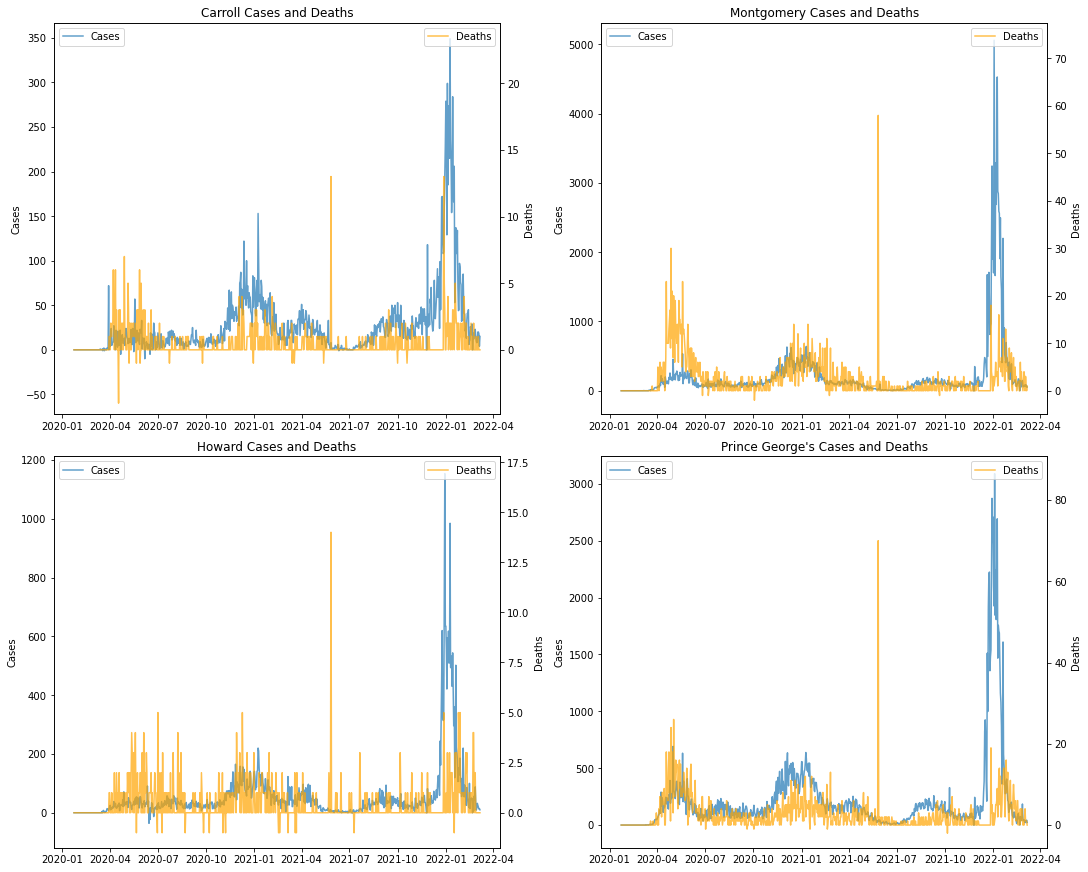

In [243]:
counties = ["Carroll", "Montgomery", "Howard", "Prince George's"]

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byCounty(ax, test_df, counties[i], ["cases", "deaths"], ["Cases", "Deaths"])

Now, it seems as if the cases and deaths peak together, but there is a day (~2021-06) where many deaths are suddenly reported. I wonder whether this peak is due to a period of underreporting that finally resolved. Curiously you can also see the peak of the Omicron variant during the holiday season of 2021. Interestingly, you can't see as much of a peak for the Delta variant (which started to predominate cases in the late summer of 2021), though it's possible that the cases are being "smoothed out" by daily reporting. It might be best for us to agglomerate these daily cases and deaths into weekly data instead, to remove some of the daily variation in reporting (including smoothing out when different reporting centers "dump" data into the state repository).

Finally, I think it's interesting that the original SARS-CoV2 variant in early-mid 2020 matches a certain ratio of deaths to cases, while Omicron has a much lower death:case ratio. This may indicate that the vaccine is clearly working, or that Omicron is significantly less virulent than the original strain (or both).

I am not sure what "negative deaths" or "negative cases" means. I will need to look back at the original data report to see if they provide an explanation.

Next, can an increase of cases in a major metropolitan area predict cases in the surrounding area? Let's look at the holiday period in Montgomery and some further-out counties.

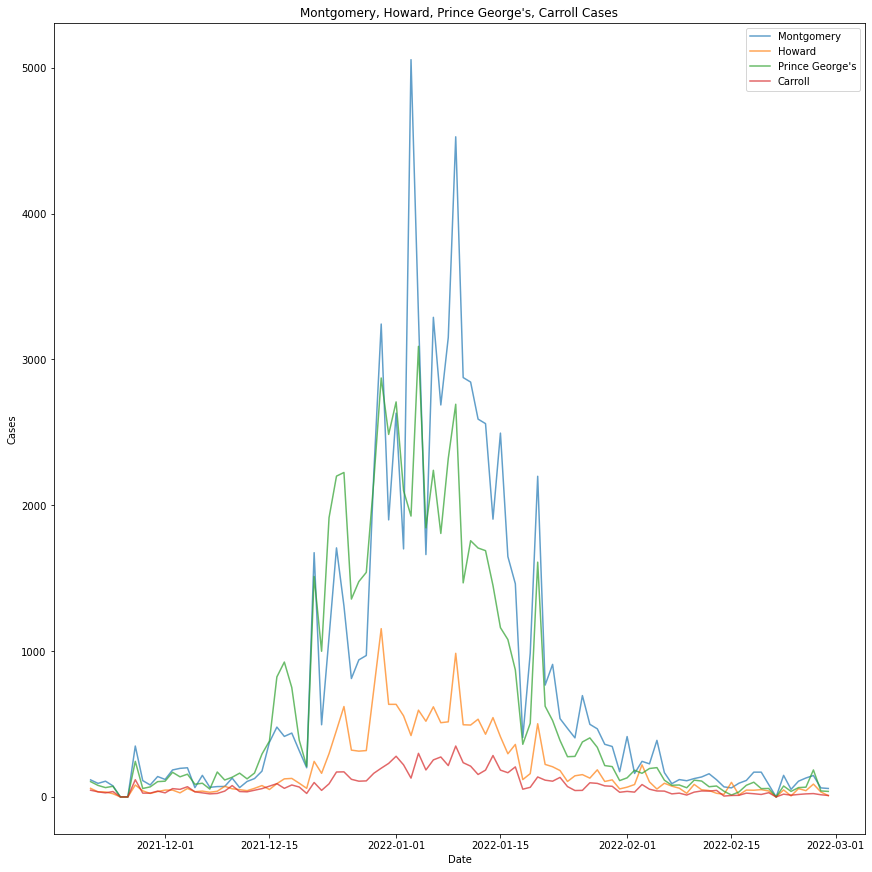

In [244]:
counties = ["Montgomery", "Howard", "Prince George's", "Carroll"]

fig, ax = plt.subplots(1,1, figsize=(12,12), constrained_layout=True)

grapher(ax, test_df, counties = counties, dates=['2021-11-20','2022-03-01'],
        series='cases', names = 'cases')

It's not entirely clear to me why Montgomery county's daily case load keeps increasing and decreasing over the set period. Again, it's possible that one/some of their testing centers only dump their data every few days, so perhaps I should change the time series step to 3-days or weekly versus daily.
In terms of the cases themselves, I'm surprised to find that they're all increasing at the same time -- I would have expected cases to appear first in the metropolitan areas of Montgomery county before spreading to the less urban areas.

Next, does vaccination status appear to correlate with death rate?

Note that this analysis should be done more rigorously with a mixed effects linear regression and cleaner data. Additionally, it would be important for us to separate our time points by dominant strains since we understand that alpha, delta, lambda, and omicron variants all had different infectivities and severity.

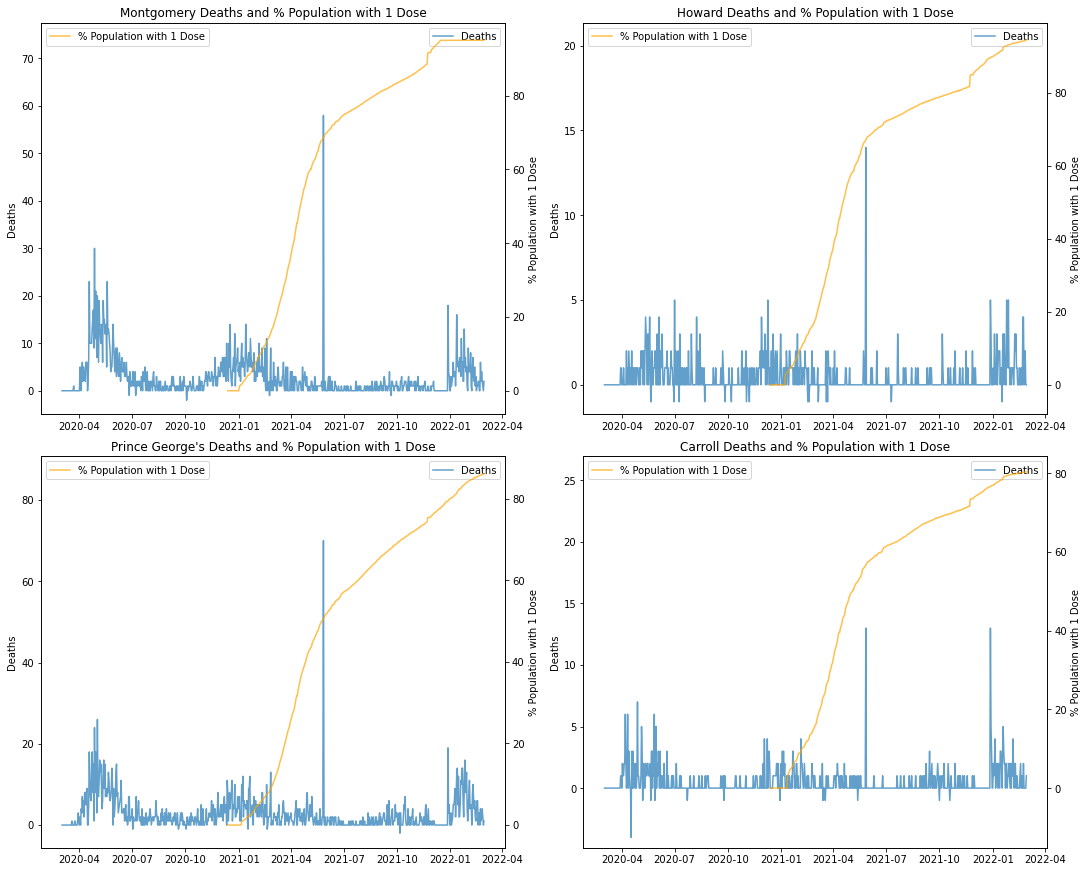

In [246]:
counties = ["Montgomery", "Howard", "Prince George's", "Carroll"]

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byCounty(ax, test_df, counties[i], ["deaths", "dose1_pop_pct"], ["Deaths", "% Population with 1 Dose"], dates=['2020-03-01', '2022-03-01'])


Fortunately for Maryland (and unfortunately for me), it looks like the rate of vaccination was quite quick, so it would be quite difficult to assess by eye whether vaccination had a long-term effect on case loads. I am sure this information will have some use when finally put into a time series model.

I also find it quite interesting how the data clearly appears sampled from a poisson distribution -- you can see the increase in stochasm for counties with lower populations, and thus, lower death rates.

*Do you feel the dataset will enable you to further progress with your project goals?*

I think so -- the data appears rich enough but it's now clear to me that the time series needs to be smoothed. I still haven't integrated the metadata into the longitudinal data so I am curious to see whether there are any features that moderate the relationship between cases and deaths, spread/peak of case loads, etc. The metadata requires a lot more cleaning than I had time for this week, so I made a few functions for now and will further automate/manually clean later.

### Now to process other non-longitudinal metadata...

#### Making a few functions to quickly and easily process metadata

In [105]:
# create a function to separate county and state

def generate_county_state(df):
    df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])
    return df

def sep_county_state(area_name):
    cs = area_name.split(",")
    county, state = cs[0], cs[1]
    
    header = find_header(county)
    
    countyNoHeader = remove_header(county, header)
    
    return countyNoHeader[:-1], state[1:] # there is a space before each state.

def remove_header(county, headers):
    ct = county.split(headers)[0]
    return ct

def find_header(county):
    header = county.split(' ')[-1]
    return header

### functions to make columns numerical and delete columns that are not fully populated.

def make_cols_numerical(df):
    numericalCols = df.columns
    numericalCols = [col for col in numericalCols if not col in ["county", "state"]]
    df[numericalCols] = np.vectorize(pd.to_numeric)(df[numericalCols], errors='coerce', downcast='float')
    return df

def find_keep_columns_by_na(df):
    na_by_col = df.isna().sum()
    keep_cols = na_by_col[na_by_col == 0].index
    keep_cols = keep_cols[~keep_cols.str.contains("Error")]
    
    df2 = df[keep_cols]
    return df2

### removes all "Total" columns except the very first one.
def keep_percent_cols(df):
    print(df.columns[0])
    keep_cols = [col for col in df.columns if any(re.findall(r'percent|county|state', col, re.IGNORECASE)) or col == df.columns[0]]
    df = df[keep_cols]
    return df

### removes all non-DMV state information. (No DC information is available, apparently)

def filters_DMV(df):
    df2 = df[df['state'].isin(["Maryland", "Virginia"])]
    return df2

### now, to do everything in one:

def process_df(df):
    df = df[df["Geographic Area Name"].str.contains(',')]
    df = generate_county_state(df)
    df = filters_DMV(df)
    df = make_cols_numerical(df)
    df = find_keep_columns_by_na(df)
    df = keep_percent_cols(df)
    return df

#### Next, let's clean the poverty metadata table

In [106]:
poverty = pd.read_csv("poverty_status.csv", low_memory=False, skiprows=1)
poverty_cleaned = process_df(poverty)
poverty_cleaned.shape

Estimate!!Total!!Population for whom poverty status is determined


/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


(46, 54)

#### Age/sex demographic characteristics

In [107]:
age_sex = pd.read_csv('age_sex.csv', skiprows=1)
age_sex_cleaned = process_df(age_sex)
age_sex_cleaned.shape

Estimate!!Total!!Total population


/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


(46, 93)

#### Health insurance characteristics

In [108]:
health_ins = pd.read_csv("health_insurance_characteristics.csv", low_memory=False, skiprows=1)
health_ins_cleaned = process_df(health_ins)
health_ins_cleaned.shape

/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


Estimate!!Total!!Civilian noninstitutionalized population


(46, 123)

#### Private Health Insurance

In [109]:
pri_health_ins = pd.read_csv("private_health_insurance.csv", low_memory=False, skiprows=1)
pri_health_ins_cleaned = process_df(pri_health_ins)
pri_health_ins_cleaned.shape

Estimate!!Total!!Civilian noninstitutionalized population


/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


(46, 36)

#### Fertility

In [110]:
fertility = pd.read_csv("fertility.csv", low_memory=False, skiprows=1)
fertility_cleaned = process_df(fertility)
fertility_cleaned.shape

/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


Estimate!!Total!!Women 15 to 50 years!!RACE AND HISPANIC OR LATINO ORIGIN!!One race!!White


(46, 10)

Fertility needs to be looked at further -- there are some locations which have NA in almost every column, suggesting that data couldn't be collected there. It'd make more sense in these cases to simply drop that row instead of dropping the entire column.

#### Income

In [111]:
income = pd.read_csv("income.csv", low_memory=False, skiprows=1)
income_cleaned = process_df(income)
income_cleaned.shape

Estimate!!Households!!Total


/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


(46, 6)

In [112]:
income_cleaned.columns

Index(['Estimate!!Households!!Total',
       'Estimate!!Households!!PERCENT ALLOCATED!!Household income in the past 12 months',
       'Estimate!!Families!!PERCENT ALLOCATED!!Family income in the past 12 months',
       'Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months',
       'county', 'state'],
      dtype='object')

Same problem with income as with fertility. I need to think of sensible conditions to justify dropping individual rows.

#### Social Characteristics

In [113]:
social = pd.read_csv("social_characteristics.csv", low_memory=False, skiprows=1)
social_cleaned = process_df(social)
social_cleaned.shape

/tmp/ipykernel_303/2898325605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["county"], df["state"] = np.vectorize(sep_county_state)(df["Geographic Area Name"])


2015 Estimate!!HOUSEHOLDS BY TYPE!!Total households


(46, 43)

In [127]:
# accepts a list of dataframes, returns a merged dataframe.
def merge_dfs(dfs):
    merged_df=dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df.drop_duplicates(subset=['state', 'county']), how='inner')
    
    return merged_df

In [128]:
df_merge = merge_dfs([poverty_cleaned, age_sex_cleaned, health_ins_cleaned, pri_health_ins_cleaned, fertility_cleaned, income_cleaned, social_cleaned])
df_merge

,Estimate!!Total!!Population for whom poverty status is determined,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!50 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!125 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!150 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!185 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!200 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!300 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!400 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!500 percent of poverty level,Estimate!!Percent below poverty level!!Population for whom poverty status is determined,...,2018 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!Different state,2018 Estimate!!YEAR OF ENTRY!!Population born outside the United States,2019 Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house in the U.S.!!Same county,2019 Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house in the U.S.!!Different county,2019 Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house in the U.S.!!Different county!!Same state,2019 Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house in the U.S.!!Different county!!Different state,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!State of residence,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!Different state,2019 Estimate!!YEAR OF ENTRY!!Population born outside the United States
0,61652.0,4843.0,12374.0,15365.0,21271.0,22167.0,34344.0,44108.0,49049.0,15.600000,...,24.400000,1219.0,7.4,5.9,3.9,2.0,97.500000,73.199997,24.299999,1746.0
1,562826.0,14997.0,41067.0,50885.0,68867.0,78496.0,144917.0,206955.0,273957.0,5.000000,...,37.700001,63298.0,6.4,7.9,4.6,3.3,89.099998,49.000000,40.099998,63080.0
2,807497.0,35860.0,90874.0,117503.0,153838.0,173078.0,273681.0,387785.0,480908.0,8.900000,...,21.900000,114653.0,5.5,5.3,4.2,1.1,86.099998,64.000000,22.100000,114884.0
3,570960.0,60266.0,143214.0,167674.0,197635.0,213478.0,314215.0,383727.0,435634.0,20.200001,...,21.900000,114653.0,5.5,5.3,4.2,1.1,86.099998,64.000000,22.100000,114884.0
4,91786.0,3913.0,5908.0,6727.0,10281.0,11935.0,16954.0,29153.0,44129.0,5.900000,...,47.400002,3376.0,6.4,3.2,2.0,1.2,95.199997,53.700001,41.500000,4429.0
5,164224.0,3986.0,11050.0,14122.0,17756.0,21218.0,40438.0,61109.0,80384.0,4.600000,...,26.500000,8921.0,3.8,5.2,3.5,1.7,95.000000,67.699997,27.299999,8382.0
6,100975.0,5552.0,15243.0,18304.0,21766.0,23892.0,35359.0,49977.0,65556.0,12.300000,...,48.400002,5265.0,4.4,5.1,2.7,2.4,95.699997,47.000000,48.700001,4386.0
7,160910.0,4215.0,12026.0,15587.0,19506.0,21846.0,37327.0,62299.0,76472.0,5.500000,...,51.799999,13826.0,5.1,5.3,3.5,1.7,91.300003,42.400002,48.799999,14254.0
8,254295.0,5659.0,18338.0,24566.0,30469.0,34271.0,64238.0,99212.0,128130.0,5.600000,...,37.900002,32524.0,7.0,4.3,2.8,1.4,87.599998,48.799999,38.700001,32311.0
9,253672.0,10550.0,23074.0,30592.0,38010.0,41205.0,67558.0,99796.0,133592.0,6.700000,...,29.799999,16957.0,5.2,4.5,2.6,1.9,93.199997,6

In [130]:
df_merge.columns

Index(['Estimate!!Total!!Population for whom poverty status is determined',
       'Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!50 percent of poverty level',
       'Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!125 percent of poverty level',
       'Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!150 percent of poverty level',
       'Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!185 percent of poverty level',
       'Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!200 percent of poverty level',
       'Estimate!!Total!!Population for whom poverty status is determined!!

In [132]:
other_metadata = pd.read_csv('CONVENIENT_us_metadata.csv', sep=',')
other_metadata

,Province_State,Admin2,Population,Lat,Long
0,Alabama,Autauga,55869,32.539527,-86.644082
1,Alabama,Baldwin,223234,30.727750,-87.722071
2,Alabama,Barbour,24686,31.868263,-85.387129
3,Alabama,Bibb,22394,32.996421,-87.125115
4,Alabama,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...
3337,Wyoming,Teton,23464,43.935225,-110.589080
3338,Wyoming,Uinta,20226,41.287818,-110.547578
3339,Wyoming,Unassigned,0,0.000000,0.000000
3340,Wyoming,Washakie,7805,43.904516,-107.680187


In [134]:
df_merge2 = df_merge.merge(other_metadata, how='left', left_on=['state','county'], right_on=['Province_State', 'Admin2'])
df_merge2

,Estimate!!Total!!Population for whom poverty status is determined,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!50 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!125 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!150 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!185 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!200 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!300 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!400 percent of poverty level,Estimate!!Total!!Population for whom poverty status is determined!!ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS!!500 percent of poverty level,Estimate!!Percent below poverty level!!Population for whom poverty status is determined,...,2019 Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house in the U.S.!!Different county!!Different state,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!State of residence,2019 Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!Different state,2019 Estimate!!YEAR OF ENTRY!!Population born outside the United States,Province_State,Admin2,Population,Lat,Long
0,61652.0,4843.0,12374.0,15365.0,21271.0,22167.0,34344.0,44108.0,49049.0,15.600000,...,2.0,97.500000,73.199997,24.299999,1746.0,Maryland,Allegany,70416,39.623576,-78.692805
1,562826.0,14997.0,41067.0,50885.0,68867.0,78496.0,144917.0,206955.0,273957.0,5.000000,...,3.3,89.099998,49.000000,40.099998,63080.0,Maryland,Anne Arundel,579234,39.006702,-76.603293
2,807497.0,35860.0,90874.0,117503.0,153838.0,173078.0,273681.0,387785.0,480908.0,8.900000,...,1.1,86.099998,64.000000,22.100000,114884.0,Maryland,Baltimore,827370,39.457847,-76.629120
3,570960.0,60266.0,143214.0,167674.0,197635.0,213478.0,314215.0,383727.0,435634.0,20.200001,...,1.1,86.099998,64.000000,22.100000,114884.0,Maryland,Baltimore,827370,39.457847,-76.629120
4,91786.0,3913.0,5908.0,6727.0,10281.0,11935.0,16954.0,29153.0,44129.0,5.900000,...,1.2,95.199997,53.700001,41.500000,4429.0,Maryland,Calvert,92525,38.539616,-76.568206
5,164224.0,3986.0,11050.0,14122.0,17756.0,21218.0,40438.0,61109.0,80384.0,4.600000,...,1.7,95.000000,67.699997,27.299999,8382.0,Maryland,Carroll,168447,39.564536,-77.023737
6,100975.0,5552.0,15243.0,18304.0,21766.0,23892.0,35359.0,49977.0,65556.0,12.300000,...,2.4,95.699997,47.000000,48.700001,4386.0,Maryland,Cecil,102855,39.566477,-75.946274
7,160910.0,4215.0,12026.0,15587.0,19506.0,21846.0,37327.0,62299.0,76472.0,5.500000,...,1.7,91.300003,42.400002,48.799999,14254.0,Maryland,Charles,163257,38.510923,-76.985807
8,254295.0,5659.0,18338.0,24566.0,30469.0,34271.0,64238.0,99212.0,128130.0,5.600000,...,1.4,87.599998,48.799999,38.700001,32311.0,Maryland,Frederick,259547,39.472966,-77.399994
9,253672.0,10550.0,23074.0,30592.0,38010.0,41205.0,67558.0,99796.0,133592.0,6.700000,...,1.9,93.199997,62.799999,30.299999,17480.0,Maryland,Harford,255441,39.550106,-76.307759


In [135]:
df_merge.to_csv("final_metadata_DMV.csv", sep=',', index=False)